## Chronos_Fx-Monthly_panel


In [ ]:
pip install chronos-forecasting

In [7]:
import pandas as pd
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")


Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['Q', 'StoxEurope', 'dI_t', 'd_pi', 'SP500', 'OSEBX', 'VIX', 'OBX_Energy', 'EUR_NOK', 'Brent']

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK – cross-learning panel) ===
Observations: 308
RMSE (level): 0.139915
MAE  (level): 0.098344
Directional accuracy: 212/307 (69.1%)

=== Diebold–Mariano vs Random Walk (cross-learning panel) ===
Loss: MSE | horizon h=1
DM-statistic: -2.1388
p-value     : 0.0324


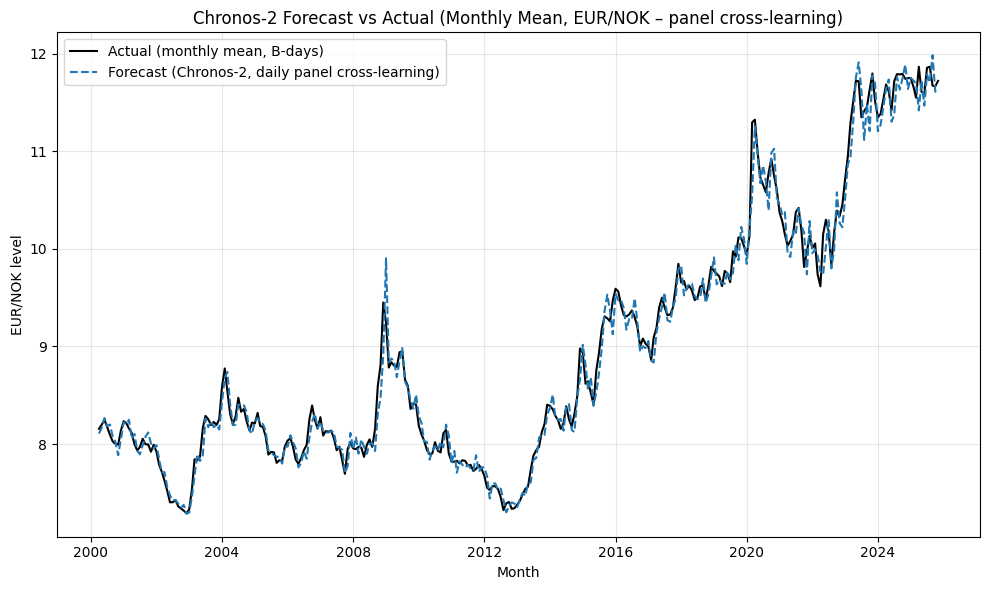

Saved: Chronos2M_daily_crosslearning.png
Saved: Chronos2M_daily_crosslearning.pdf


In [11]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (monthly, levels) with daily panel and macro covariates
Cross-learning setup:
  - Data: daily, multiple financial series as separate items
    (EUR_NOK, Brent, VIX, StoxEurope, SP500, OSEBX, OBX_Energy)
  - Macros: Q, d_pi, dI_t as past-only covariates (no future_df -> no leakage)
  - Cut: last business day of previous month (based on EUR_NOK B-days)
  - Forecast: next calendar month at daily frequency,
              aggregated to monthly mean over business days (EUR_NOK only)
"""

from __future__ import annotations
import io, time, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # from chronos-forecasting>=2.0

# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    m_freq: str = "M"          # monthly evaluation
    min_hist_days: int = 40    # minimum number of daily obs before first forecast
    max_context: int = 2048
    max_horizon: int = 64      # must exceed longest month (~31 days); 64 is a safe margin
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2M_daily_crosslearning.png"
    fig_pdf: str = "Chronos2M_daily_crosslearning.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"
PANEL_SERIES = [
    "EUR_NOK",
    "Brent",
    "VIX",
    "StoxEurope",
    "SP500",
    "OSEBX",
    "OBX_Energy",
]
MACRO_COLS = ["Q", "d_pi", "dI_t"]

# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    """Download CSV with simple retry/backoff."""
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")

# -----------------------------
# Data loading: daily EUR_NOK (B + D) + full panel DF_d
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Load daily CSV with columns:
      Date, EUR_NOK, Q, d_pi, dI_t, Brent, VIX,
      StoxEurope, SP500, OSEBX, OBX_Energy

    Returns:
      S_b  : EUR_NOK on business days (B) with ffill (for cut and monthly ground truth)
      DF_d : daily (D) wide DataFrame with all PANEL_SERIES + MACRO_COLS
             (calendar days, forward-filled)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {
        "Date", "EUR_NOK", "Q", "d_pi", "dI_t",
        "Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"
    }
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[list(required_cols)]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", "EUR_NOK"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    # Ensure numeric types for all non-date columns
    num_cols = list(required_cols - {"Date"})
    for col in num_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["EUR_NOK"])

    # Business-day EUR_NOK (ground truth / aggregation base)
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Daily wide DF_d (calendar days, forward-filled)
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

# -----------------------------
# Build panel context (wide -> long)
# -----------------------------
def make_panel_context(df_wide: pd.DataFrame) -> pd.DataFrame:
    """
    Convert a wide daily DataFrame into a panel (long) format.

    Input:
      df_wide: daily wide DF with columns PANEL_SERIES + MACRO_COLS

    Output:
      panel_df with columns:
        ['item_id', 'timestamp', 'target', <MACRO_COLS>]
      one row per (DATE, item_id)
    """
    df = df_wide.copy()

    # Macroeconomic covariates are shared across items (same value per date)
    macros = df[MACRO_COLS].copy()

    panel_list = []
    for series_name in PANEL_SERIES:
        tmp = pd.DataFrame({
            "timestamp": df.index,
            "item_id": series_name,
            "target": df[series_name].values,
        })
        # Attach macro covariates (same for all items at a given timestamp)
        for col in MACRO_COLS:
            tmp[col] = macros[col].values
        panel_list.append(tmp)

    panel_df = pd.concat(panel_list, axis=0, ignore_index=True)
    panel_df = panel_df.sort_values(["item_id", "timestamp"])
    return panel_df

# -----------------------------
# Chronos-2 model builder (panel, past-only macros)
# -----------------------------
def build_model_chronos2(
    max_context: int,
    horizon_len: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    """
    Build a Chronos-2 forecasting function operating on a panel.

    Returns:
      forecast_fn(panel_context_df, H) -> DataFrame with columns:
        ['item_id', 'timestamp', 'y_pred']

    panel_context_df:
      columns: ['item_id', 'timestamp', 'target', <MACRO_COLS>]
      multiple series (EUR_NOK, Brent, VIX, ...),
      macro columns are used as past-only covariates.
    """
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install a CUDA build of PyTorch and a recent NVIDIA driver.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        """
        Convert Chronos output to a panel DataFrame [item_id, timestamp, y_pred].
        """
        df = pred.copy()
        if "timestamp" in df.columns:
            if "item_id" in df.columns:
                df = df.sort_values(["item_id", "timestamp"])
            else:
                df = df.sort_values("timestamp")

        # Try common column conventions for the median prediction
        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Chronos2 predict_df: unsupported schema. Columns={list(df.columns)}.")

        keep_cols = [c for c in ["item_id", "timestamp", "y_pred"] if c in df.columns]
        return df[keep_cols].copy()

    def _forecast(panel_context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        """
        Run Chronos-2 on the entire panel context and obtain forecasts for all items.

        Input:
          panel_context_df: full history up to the cut date, panel format.

        Output:
          DataFrame with predicted values for horizon H for each item_id.
        """
        ctx = panel_context_df.copy()

        with torch.inference_mode():
            pred = pipeline.predict_df(
                ctx,
                prediction_length=H,
                quantile_levels=[0.5],  # median only
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                # IMPORTANT:
                # We do NOT pass future_df here. Macros are interpreted as past covariates only.
            )

        df_pred = _extract_median(pred)
        return df_pred

    return _forecast

# -----------------------------
# Monthly walk-forward on daily data, EUR_NOK eval, panel context
# -----------------------------
def walk_forward_chronos2_monthly_panel(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
) -> pd.DataFrame:
    """
    Monthly walk-forward evaluation based on daily panel forecasts.

    For each calendar month m:
      - Cut at last business day of previous month (based on EUR_NOK series S_b).
      - Use all daily observations up to and including cut (DF_d) to build the panel context:
          PANEL_SERIES as separate items, MACRO_COLS as covariates.
      - Forecast the full next calendar month at daily frequency for all items.
      - Aggregate EUR_NOK forecasts to the monthly mean over business days.
      - Compare to the actual EUR_NOK monthly mean from S_b.

    Cross-learning:
      - The model sees the entire panel as context.
    Evaluation:
      - Only EUR_NOK is evaluated.
    """
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        # Cut at last business day of previous month
        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        # Daily history up to and including cut (wide format)
        hist_wide = DF_d.loc[:cut]
        if hist_wide.shape[0] < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        # Business days inside the target month
        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue
        y_true = float(S_b.loc[idx_m_b].mean())

        # Horizon = full calendar month length (inclusive)
        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        # Build panel context up to cut
        panel_ctx = make_panel_context(hist_wide)

        # Forecast panel for the next month (all item_id)
        df_pred = forecast_fn(panel_ctx, H)
        if df_pred.empty:
            dropped[str(m)] = "no_predictions"
            continue

        # Define the daily index for the forecast horizon
        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")

        # Extract EUR_NOK predictions
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy()

        # Align predicted EUR_NOK series with f_idx
        if "timestamp" in df_fx.columns:
            df_fx = df_fx.sort_values("timestamp")
            pred_daily = pd.Series(index=f_idx, dtype=float, name="point")
            tmp = df_fx.set_index("timestamp")["y_pred"]
            # Use exact timestamp matches where available
            common_idx = tmp.index.intersection(pred_daily.index)
            pred_daily.loc[common_idx] = tmp.loc[common_idx]
            # Conservative forward fill for any small gaps
            pred_daily = pred_daily.ffill()
        else:
            # Fallback: assume direct H-step alignment if timestamps are missing
            pred_daily = pd.Series(df_fx["y_pred"].values[:H], index=f_idx, name="point")

        # Aggregate forecast to business-day mean over the month
        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"month": m, "cut": cut, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if m not in df.index]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")
    return df

# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate(eval_df: pd.DataFrame) -> pd.DataFrame:
    """Compute level errors and directional accuracy."""
    df = eval_df.copy()
    df["err"] = df["y_true"] - df["y_pred"]
    core = df.dropna(subset=["y_true", "y_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    # Directional accuracy vs previous month
    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK – cross-learning panel) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core

# -----------------------------
# Diebold–Mariano (vs Random Walk)
# -----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse",
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy.
    Returns (DM statistic, p-value). Uses simple Newey–West/Bartlett HAC up to lag h-1.
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = np.abs(e_m) - np.abs(e_r) if loss.lower() == "mae" else (e_m**2) - (e_r**2)

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val

def dm_against_random_walk(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """Random walk benchmark: previous month's observed level (y_{t-1})."""
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)
    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)
    print("\n=== Diebold–Mariano vs Random Walk (cross-learning panel) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")

# -----------------------------
# Plot (no bands)
# -----------------------------
def plot_monthly_simple(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    """Simple line plot: actual vs forecast (monthly mean, EUR/NOK)."""
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--",
             label="Forecast (Chronos-2, daily panel cross-learning)")

    plt.title("Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK – panel cross-learning)")
    plt.xlabel("Month")
    plt.ylabel("EUR/NOK level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")

# -----------------------------
# Main
# -----------------------------
def main():
    # 1) Load data
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # 2) Build model (Chronos-2) – panel, macros as past-only covariates
    forecast_fn = build_model_chronos2(
        max_context=CFG.max_context,
        horizon_len=min(CFG.max_horizon, 64),
    )

    # 3) Monthly walk-forward (panel) and evaluation
    df_eval = walk_forward_chronos2_monthly_panel(S_b, DF_d, forecast_fn)
    eval_df = evaluate(df_eval)

    # 4) Diebold–Mariano vs Random Walk (MSE; h=1)
    dm_against_random_walk(eval_df, loss="mse", h=1)

    # 5) Plot results
    plot_monthly_simple(eval_df, CFG.fig_png, CFG.fig_pdf)

if __name__ == "__main__":
    main()
